# Guideline: Simulating and Training for the OmniNeck

This notebook is a guide on how to simulate the OmniNeck in Abaqus to generate the dataset for training the NeckNet model.

Here are some necessary packages and functions needed to be imported.

In [2]:
import os
import platform
import re
import shutil
import csv
import random
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R
from omnineck.models import NeckNetRuntime

## Input File Template

The `.inp` file is necessary for Abaqus simulation. It contains the information about the geometry, material properties, boundary conditions, history and field outputs, etc. Here we provide typical steps to create an `.inp` file template for the OmniNeck.


### Part

After opening the Abaqus CAE, we create a new model database with standard/explicit model. Then we import the `omnineck.STEP` file to create a part. The part can be named as `omnineck`.

### Property

In the `Property` module, we create a new material `PU`, select `Mechanical` -> `Elasticity` -> `Elastic`, and input `Young's modulus=0.2` and `Poisson's ratio=0.4`. Then we create a new `Section` with `Solid` -> `Homogeneous` type, select the `Material` we just created. After that, we need to assign the `Section` to the part by selecting the part and clicking `Assign Section`. Now the material properties are defined, and the color of the part becomes green.


### Assembly

In the `Assembly` module, we can add the part to the assembly by selecting `Instance` -> `Create` -> `Part` -> `OK`. Note that we set `Instance Type` as `Dependent (mesh on part)`. The axis origin is at the center of the bottom surface of the cylinder, which is convenient for the following steps.

And we need to define several sets, reference points, and surfaces:

- `RP-1`: create a reference point at (0, 0, 25.75), representing the center of the marker.
- `Set-RP-1`: create a set and select the reference point `RP-1`.
- `Set-surface`: create a set and select all surfaces of the OmniNeck.
- `Set-bottom`: create a set and select the bottom surface of the OmniNeck.
- `Set-zero`: create a set and select the surfaces on which displacements are zero.
- `Surf-bottom`: create a surface and select the bottom surface of the OmniNeck.
- `Surf-bound`: create a surface and select the lower layer of the OmniNeck, which is bounded by the marker.

### Step

In `Step` module, we create a new `Step` with `Static, General` type, and set `Nlgeom` as `On`. Then we need to edit the `Field Output` and select `S, U` as the output variables. For the `History Output`, the domain needs to be selected as `Integrated output section` which needs to be created with `Surf-bottom`, and the output variables are `SOF, SOM`. Since we mainly consider the geometry and force information, other output variables can be ignored. If you are interested in other variables, you can add them as well.

### Interaction

In the `Interaction` module, we need to define the constraints between `RP-1` and `Surf-bound`. `Coupling` type `Constraint` is created with `Set-RP-1` selected as `Control points` and `Surf-bound` selected as `Surface`. The `Coupling type` is set as `Kinematic`, and the `Constrained degrees of freedom` are set as all. Therefore, the `Surf-bound` is slaved by changing the position of `RP-1`.

### Load

In the `Load` module, we create two boundary conditions. We first create a `BC-bottom` with `Symmetry/Antisymmetry/Encastre` type at `Initial` step, and select `Set-bottom` as the `Region` and `ENCASTRE` as the `Boundary condition`. Then we create a `BC-RP` with `Displacement/Rotation` type at `Step-1` step, and select `Set-RP-1` as the `Region` and all degrees of freedom with `0` or other values.


### Mesh

In the `Mesh` module, we need to first select the `Mesh controls` and set the `Element shape` as `Tet`. Then we need to make the element type as `C3D4` by selecting `Mesh` -> `Element type` and changing the `Geometric Order` as `Linear`, and the color of the geometry becomes pink. It's optional to refine the mesh by selecting `Seed part` and setting the `Approximate global size`, `Maximum deviation factor`, and `Minimum size`. Then we generate the mesh by selecting `Mesh part`.

### Job

After all above steps, we can create the job to generate the `.inp` file. We can select `Create` in `Job manager`, and click the `Data Check` to check whether there are any errors. If there is no error, we can click `Write input` to generate the `.inp` file. The `.inp` file is saved in the working directory, and we moved it to the `template` folder.

## Visualization

We can visualize the mesh using `plotly`. The `node.txt`, `element.txt`, `surf_node.txt`, and `zero_node.txt` in the `./template/` folder are copied from the `omnineck.inp` file. The `surf_tri.txt`, `surf_coor.txt`, and `def_node.txt` are generated.

First, we need to define the type of the metaball:

In [3]:
# Define the omnineck type
omnineck_type = "omnineck"

# Define the template directory
template_dir = os.path.join("..", "templates", omnineck_type)
if not os.path.exists(template_dir):
    raise FileNotFoundError(
        f"⚠️ Template directory '{template_dir}' does not exist. Please ensure the template is available."
    )
    
# Define the data directory
data_dir = os.path.join("..", "data", omnineck_type, "sim")
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

Then we extract the node and element information from the `.inp` file:

In [3]:
# Define the inp file path
inp_path=os.path.join(template_dir, f'{omnineck_type}.inp')
# Check if the input file exists
if not os.path.exists(inp_path):
    raise FileNotFoundError(
        f"⚠️ Input file '{inp_path}' does not exist. Please ensure the input file is available."
    )

# Function to check if a line is a valid node line
def is_valid_node_line(line) -> bool:
    parts = line.split(',')
    return len(parts) >= 4 and parts[0].strip().isdigit()

# Function to check if a line is a valid element line
def is_valid_elem_line(line) -> bool:
    parts = line.split(',')
    return len(parts) >= 2 and parts[0].strip().isdigit()

# Read the inp file
with open(inp_path, 'r') as f:
    lines = f.readlines()

# Initialize lists to hold node and element lines
node_lines = []
elem_lines = []

# Flags to track reading state
reading_nodes = False
reading_elems = False
node_parsed = False
elem_parsed = False

# Process the lines to extract nodes and elements
for line in lines:
    striped = line.strip()
    
    if striped.lower().startswith('*node') and not node_parsed:
        reading_nodes = True
        reading_elems = False
        continue
    elif striped.lower().startswith('*element') and not elem_parsed:
        reading_nodes = False
        reading_elems = True
        continue
    elif striped.startswith('*'):
        reading_nodes = False
        reading_elems = False

    if reading_nodes:
        if is_valid_node_line(striped):
            node_lines.append(striped)
        else:
            reading_nodes = False
            node_parsed = True
    elif reading_elems:
        if is_valid_elem_line(striped):
            elem_lines.append(striped)
        else:
            reading_elems = False
            elem_parsed = True

# Save the node and element lines to their respective text files
node_txt_path=os.path.join(template_dir, 'node.txt')
with open(node_txt_path, 'w') as f:
    for line in node_lines:
        f.write(line + '\n')
element_txt_path=os.path.join(template_dir, 'element.txt')
with open(element_txt_path, 'w') as f:
    for line in elem_lines:
        f.write(line + '\n')
print(f"✅ Nodes saved to: {node_txt_path}")
print(f"✅ Elements saved to: {element_txt_path}")


✅ Nodes saved to: ..\templates\omnineck\node.txt
✅ Elements saved to: ..\templates\omnineck\element.txt


We also need to extract the surface node and zero node information from the `.inp` file:

In [4]:
# Define the target sets to extract
target_sets=['Set-bound', 'Set-surface', 'Set-zero']

# Function to parse generate lines
def parse_generate(start, end, step) -> list:
    return list(range(int(start), int(end) + 1, int(step)))

# Read the inp file
with open(inp_path, 'r') as f:
    lines = f.readlines()

# Initialize a dictionary to hold nset data
nset_data = {name: [] for name in target_sets}
# Flags to track current set and generate state
current_set = None
is_generate = False

# Process the lines to extract nset data
for line in lines:
    striped = line.strip()

    if striped.lower().startswith('*nset'):
        match = re.search(r'nset\s*=\s*([\w\-]+)', striped, re.IGNORECASE)
        if match:
            set_name = match.group(1)
            if set_name in target_sets:
                current_set = set_name
                is_generate = 'generate' in striped.lower()
            else:
                current_set = None
        continue

    if striped.startswith('*'):
        current_set = None
        is_generate = False
        continue

    if current_set:
        if is_generate:
            parts = re.split(r'[,\s]+', striped)
            if len(parts) >= 3:
                start, end, step = parts[:3]
                nset_data[current_set].extend(parse_generate(start, end, step))
        else:
            nums = [int(s) for s in re.split(r'[,\s]+', striped) if s.strip().isdigit()]
            nset_data[current_set].extend(nums)

# Save each nset to its respective text file
for set_name, nodes in nset_data.items():
    out_path = os.path.join(template_dir, f"{set_name.split('-')[1]}_node.txt")
    with open(out_path, 'w') as f:
        for node_id in sorted(set(nodes)):
            f.write(f"{node_id}\n")
    print(f"✅ Nset '{set_name}' saved to: {out_path}")

✅ Nset 'Set-bound' saved to: ..\templates\omnineck\bound_node.txt
✅ Nset 'Set-surface' saved to: ..\templates\omnineck\surface_node.txt
✅ Nset 'Set-zero' saved to: ..\templates\omnineck\zero_node.txt


Then we need to generate the surface triangle, surface coordinate, and deform node information:

In [5]:
# Define paths for the generated files
triangle_txt_path = os.path.join(template_dir, "triangle.txt")
surface_node_txt_path = os.path.join(template_dir, "surface_node.txt")
surface_triangle_txt_path = os.path.join(template_dir, "surface_triangle.txt")
surface_coordinate_txt_path = os.path.join(template_dir, "surface_coordinate.txt")
zero_node_txt_path = os.path.join(template_dir, "zero_node.txt")
deform_node_txt_path = os.path.join(template_dir, "deform_node.txt")

# Generate triangle.txt
element = np.loadtxt(element_txt_path, dtype=int, delimiter=",")
triangle = []
for i in range(element.shape[0]):
    triangle.append([element[i, 1], element[i, 2], element[i, 3]])
    triangle.append([element[i, 1], element[i, 3], element[i, 4]])
    triangle.append([element[i, 1], element[i, 2], element[i, 4]])
    triangle.append([element[i, 2], element[i, 3], element[i, 4]])
triangle = np.array(triangle, dtype=int)
triangle = np.sort(triangle, axis=1)
triangle = np.array(list(set([tuple(t) for t in triangle])), dtype=int)
np.savetxt(triangle_txt_path, triangle, fmt="%d", delimiter=",")
print(f"✅ Triangles saved to: {triangle_txt_path}")

# Generate surface_coordinate.txt
surface_node = np.loadtxt(surface_node_txt_path, dtype=int)
node = np.loadtxt(node_txt_path, dtype=float, delimiter=",")
surface_coordinate = []
for i in range(surface_node.shape[0]):
    if node[i, 0] in surface_node:
        surface_coordinate.append(node[i, 1:])
surface_coordinate = np.array(surface_coordinate)
np.savetxt(surface_coordinate_txt_path, surface_coordinate, fmt="%.6f", delimiter=",")
print(f"✅ Surface node coordinates saved to: {surface_coordinate_txt_path}")

# Generate deform_node.txt
zero_node = np.loadtxt(zero_node_txt_path, dtype=int)
deform_node = []
for i in range(surface_node.shape[0]):
    if surface_node[i] not in zero_node:
        deform_node.append(surface_node[i])
deform_node = np.array(deform_node, dtype=int)
np.savetxt(deform_node_txt_path, deform_node, fmt="%d", delimiter=",")
print(f"✅ Deform nodes saved to: {deform_node_txt_path}")

# Generate surface_triangle.txt
surface_triangle = []
surface_node = surface_node.tolist()
for i in range(triangle.shape[0]):
    if all([triangle[i, j] in surface_node for j in range(3)]):
        surface_triangle.append(triangle[i])
surface_triangle = np.array(surface_triangle, dtype=int)
np.savetxt(surface_triangle_txt_path, surface_triangle, fmt="%d", delimiter=",")
print(f"✅ Surface triangles saved to: {surface_triangle_txt_path}")

✅ Triangles saved to: ..\templates\omnineck\triangle.txt
✅ Surface node coordinates saved to: ..\templates\omnineck\surface_coordinate.txt
✅ Deform nodes saved to: ..\templates\omnineck\deform_node.txt
✅ Surface triangles saved to: ..\templates\omnineck\surface_triangle.txt


Then we can visualize the mesh in 3D:

In [6]:
# Load mesh
node_ori = np.loadtxt(surface_coordinate_txt_path, delimiter=",")
mesh_triangle = np.loadtxt(surface_triangle_txt_path, dtype=int, delimiter=",") - 1
deform_node = np.loadtxt(deform_node_txt_path, dtype=int)
node_curr = node_ori.copy()
mesh3d = go.Mesh3d(
    x=node_curr[:, 0],
    y=node_curr[:, 1],
    z=node_curr[:, 2],
    i=mesh_triangle[:, 0],
    j=mesh_triangle[:, 1],
    k=mesh_triangle[:, 2],
    intensity=np.linalg.norm(node_curr - node_ori, axis=1),
    colorscale="Viridis",
    autocolorscale=False,
    colorbar=dict(
        title=dict(
            text="Displacement (mm)",
            side="right",
            font=dict(size=16, family="Arial"),
        ),
        tickvals=[0, 4, 8, 12],
        tickfont=dict(size=14, family="Arial"),
        len=0.5,
    ),
    cmin=0,
    cmax=12,
    showscale=True,
    flatshading=True,
)
fig = go.Figure(data=[mesh3d])
fig.update_layout(
    scene=dict(
        camera=dict(
            eye=dict(x=1, y=1, z=1),
            projection=dict(type="orthographic"),
        ),
        xaxis=dict(nticks=4, range=[-50, 50]),
        yaxis=dict(nticks=4, range=[-50, 50]),
        zaxis=dict(nticks=4, range=[0, 100]),
        aspectmode="manual",
        aspectratio=go.layout.scene.Aspectratio(x=1, y=1, z=1),
    ),
    margin=dict(l=0, r=0, b=0, t=0, pad=0),
)
fig.show()

## Pose Generation

To generate motion data of the `RP-1`, we need to define `motion_path`, representing the path to save the motion data, and `data_num`, representing the number of data to generate. Then we can generate the motion, including `u1`, `u2`, `u3`, `r1`, `r2`, `r3`.


In [10]:
# Define the number of data to generate
data_number = 100000

# Define the data directory
data_dir = os.path.join("..", "data", omnineck_type, "sim")
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Define the path to save the motion data
motion_csv_path = os.path.join(data_dir, "motion.csv")
# Generate motion.csv
csv_file = open(motion_csv_path, "w", encoding="utf-8", newline="")
csv_writer = csv.writer(csv_file)
count = 0
while count < data_number:
    u1 = random.uniform(-10, 10)
    u2 = random.uniform(-10, 10)
    u3 = random.uniform(-4, 2)
    ur1 = random.uniform(0, 0.3) * (1 if u2 < 0 else -1)
    ur2 = random.uniform(0, 0.3) * (1 if u1 > 0 else -1)
    ur3 = random.uniform(-0.3, 0.3)
    count += 1
    csv_writer.writerow(
        [
            count,
            np.around(u1, 3),
            np.around(u2, 3),
            np.around(u3, 3),
            np.around(ur1, 2),
            np.around(ur2, 2),
            np.around(ur3, 2),
        ]
    )
csv_file.close()
print(f"✅ Motion saved to: {motion_csv_path}")

✅ Motion saved to: ..\data\omnineck\sim\motion.csv


The range of `u1`, `u2`, `u3`, `r1`, `r2`, `r3` can be adjusted according to the actual situation. The motion data will be saved as `motion.csv` in the defined path.

In [11]:
# Save the motion data to npy
motion = np.loadtxt(motion_csv_path, delimiter=",")
print("motion head:\n", motion[:5])
motion_npy_path = os.path.join(data_dir, "motion.npy")
np.save(motion_npy_path, motion[:, 1:])
print(f"✅ Motion saved to: {motion_npy_path}")

motion head:
 [[ 1.     9.825 -4.382 -1.092  0.28   0.26   0.29 ]
 [ 2.    -7.643  0.208 -1.912 -0.2   -0.2   -0.09 ]
 [ 3.    -1.216 -1.85  -0.512  0.24  -0.13   0.05 ]
 [ 4.    -4.2   -3.495 -0.206  0.25  -0.21   0.29 ]
 [ 5.     3.975 -8.796 -3.425  0.03   0.19   0.28 ]]
✅ Motion saved to: ..\data\omnineck\sim\motion.npy


## Input File Generation

To generate the input files based on the motion data and the template, we need to replace lines corresponding to `BC-bound` with the following text:

```text
** Name: BC_2 Type: Displacement/Rotation
*Boundary
Set-RP-1, 1, 1, u1
Set-RP-1, 2, 2, u2
Set-RP-1, 3, 3, u3
Set-RP-1, 4, 4, ur1
Set-RP-1, 5, 5, ur2
Set-RP-1, 6, 6, ur3
```

To faster the simulation, we separate the simulation into multiple parts and run them in parallel. Here is an example for generating the input files:

In [12]:
# Define the parallel number
parallel_number = 10

# Read metaball.inp
with open(inp_path, "r") as f:
    template = f.read()

# Read motion.csv
motion_list = pd.read_csv(motion_csv_path, header=None)

# Separate the motion data
for i in range(parallel_number):
    motion_list.iloc[
        int(len(motion_list) / parallel_number * i) : int(
            len(motion_list) / parallel_number * (i + 1)
        )
    ].to_csv(os.path.join(data_dir, f"motion_{i + 1}.csv"), header=None, index=None)

# Generate input files
for i in range(1, parallel_number + 1):
    motion_i_csv_path = os.path.join(data_dir, f"motion_{i}.csv")
    motion_i_list = pd.read_csv(motion_i_csv_path, header=None)
    inp_i_dir = os.path.join(data_dir, f"inp_{i}")
    os.makedirs(inp_i_dir, exist_ok=True)
    for j in tqdm(range(len(motion_i_list)), desc=f"Generating inputs for part {i}", ncols=100):
        # Read the motion data
        count, u1, u2, u3, ur1, ur2, ur3 = motion_i_list.iloc[j, :]
        # Replace the template with the motion data
        inp = (
            template.replace("u1", str(u1))
            .replace("u2", str(u2))
            .replace("u3", str(u3))
            .replace("ur1", str(ur1))
            .replace("ur2", str(ur2))
            .replace("ur3", str(ur3))
        )
        # Write the input file
        with open(os.path.join(inp_i_dir, f"{int(count)}.inp"), "w") as f:
            f.write(inp)
    # Remove the motion_i.csv file
    os.remove(motion_i_csv_path)
    print(f"✅ Input files for part {i} generated in: {inp_i_dir}")

Generating inputs for part 1: 100%|██████████████████████████| 10000/10000 [00:32<00:00, 310.44it/s]


✅ Input files for part 1 generated in: ..\data\omnineck\sim\inp_1


Generating inputs for part 2: 100%|██████████████████████████| 10000/10000 [00:37<00:00, 265.81it/s]


✅ Input files for part 2 generated in: ..\data\omnineck\sim\inp_2


Generating inputs for part 3: 100%|██████████████████████████| 10000/10000 [00:37<00:00, 265.40it/s]


✅ Input files for part 3 generated in: ..\data\omnineck\sim\inp_3


Generating inputs for part 4: 100%|██████████████████████████| 10000/10000 [00:34<00:00, 287.71it/s]


✅ Input files for part 4 generated in: ..\data\omnineck\sim\inp_4


Generating inputs for part 5: 100%|██████████████████████████| 10000/10000 [00:37<00:00, 266.21it/s]


✅ Input files for part 5 generated in: ..\data\omnineck\sim\inp_5


Generating inputs for part 6: 100%|██████████████████████████| 10000/10000 [00:35<00:00, 280.20it/s]


✅ Input files for part 6 generated in: ..\data\omnineck\sim\inp_6


Generating inputs for part 7: 100%|██████████████████████████| 10000/10000 [00:35<00:00, 279.87it/s]


✅ Input files for part 7 generated in: ..\data\omnineck\sim\inp_7


Generating inputs for part 8: 100%|██████████████████████████| 10000/10000 [00:34<00:00, 287.03it/s]


✅ Input files for part 8 generated in: ..\data\omnineck\sim\inp_8


Generating inputs for part 9: 100%|██████████████████████████| 10000/10000 [00:33<00:00, 302.56it/s]


✅ Input files for part 9 generated in: ..\data\omnineck\sim\inp_9


Generating inputs for part 10: 100%|█████████████████████████| 10000/10000 [00:35<00:00, 278.04it/s]

✅ Input files for part 10 generated in: ..\data\omnineck\sim\inp_10


## Batch Submission

We use the following command to submit a single job:

`Terminal` (Linux):

```bash [Linux]
abq job={JOB_NAME} cpus=4 int
```

`PowerShell` (Windows):

```bash [Windows]
abaqus job={JOB_NAME} cpus=4 int
```

For Abaqus 2022, the CLI is `abq` in Linux and `abaqus` in Windows, which may be different in other versions.

To submit multiple jobs in batch, we first need a `.sh` (Linux) or `.bat` (Windows) file.


Copy the `.sh` or `.bat` file to each directory containing the `.inp` files:

In [13]:
is_windows = platform.system() == "Windows"
src_ext = "bat" if is_windows else "sh"
src_file_path = os.path.join("..", "scripts", f"run.{src_ext}")

for i in range(1, parallel_number + 1):
    dst_file_path = os.path.join(data_dir, f"inp_{i}", f"run.{src_ext}")
    shutil.copy(src_file_path, dst_file_path)
    print(f"✅ Run script copied to: {dst_file_path}")

✅ Run script copied to: ..\data\omnineck\sim\inp_1\run.bat
✅ Run script copied to: ..\data\omnineck\sim\inp_2\run.bat
✅ Run script copied to: ..\data\omnineck\sim\inp_3\run.bat
✅ Run script copied to: ..\data\omnineck\sim\inp_4\run.bat
✅ Run script copied to: ..\data\omnineck\sim\inp_5\run.bat
✅ Run script copied to: ..\data\omnineck\sim\inp_6\run.bat
✅ Run script copied to: ..\data\omnineck\sim\inp_7\run.bat
✅ Run script copied to: ..\data\omnineck\sim\inp_8\run.bat
✅ Run script copied to: ..\data\omnineck\sim\inp_9\run.bat
✅ Run script copied to: ..\data\omnineck\sim\inp_10\run.bat


Then run in the `Terminal` (Linux):

```bash
cd /path/to/each/inp_*
sudo chmod +x run.sh
bash run.sh
```

or `PowerShell` (Windows):

```bash
cd /path/to/each/inp_*
.\run.bat
```

to submit all jobs in batch.

It will take some time to finish the simulation, so please be patient.

## Data Post-processing

After the simulation, we first move all file into one directory:

In [3]:
data_dir = os.path.join("..", "data", omnineck_type, "sim")
if not os.path.exists(data_dir):
    raise FileNotFoundError(
        f"⚠️ Data directory '{data_dir}' does not exist. Please ensure the data is available."
    )

parallel_number = len([d for d in os.listdir(data_dir) if d.startswith("inp_")])

abq_dir = os.path.join(data_dir, "abq_files")
os.makedirs(abq_dir, exist_ok=True)

for i in range(1, parallel_number + 1):
    inp_i_dir = os.path.join(data_dir, f"inp_{i}")
    
    if not os.path.exists(inp_i_dir):
        print(f"⚠️ Warning: source path {inp_i_dir} does not exist, skipping.")
        continue

    for file in tqdm(os.listdir(inp_i_dir), desc=f"Moving files for part {i}", ncols=100):
        src_file = os.path.join(inp_i_dir, file)
        dst_file = os.path.join(abq_dir, file)

        if os.path.exists(dst_file):
            os.remove(dst_file)
        shutil.move(src_file, dst_file)

    try:
        os.rmdir(inp_i_dir)
    except OSError:
        print(f"⚠️ Warning: failed to remove {inp_i_dir}, not empty or in use.")
        
    print(f"✅ Input files for part {i} moved to: {abq_dir}")

Moving files for part 1: 100%|██████████████████████████████| 70000/70000 [00:12<00:00, 5597.09it/s]


✅ Input files for part 1 moved to: ../data/omnineck/sim/abq_files


Moving files for part 2: 100%|██████████████████████████████| 70001/70001 [00:12<00:00, 5592.59it/s]


✅ Input files for part 2 moved to: ../data/omnineck/sim/abq_files


Moving files for part 3: 100%|██████████████████████████████| 70002/70002 [00:12<00:00, 5489.28it/s]


✅ Input files for part 3 moved to: ../data/omnineck/sim/abq_files


Moving files for part 4: 100%|██████████████████████████████| 70001/70001 [00:12<00:00, 5565.13it/s]


✅ Input files for part 4 moved to: ../data/omnineck/sim/abq_files


Moving files for part 5: 100%|██████████████████████████████| 70001/70001 [00:12<00:00, 5459.26it/s]


✅ Input files for part 5 moved to: ../data/omnineck/sim/abq_files


Moving files for part 6: 100%|██████████████████████████████| 70001/70001 [00:12<00:00, 5532.28it/s]


✅ Input files for part 6 moved to: ../data/omnineck/sim/abq_files


Moving files for part 7: 100%|██████████████████████████████| 70001/70001 [00:12<00:00, 5515.29it/s]


✅ Input files for part 7 moved to: ../data/omnineck/sim/abq_files


Moving files for part 8: 100%|██████████████████████████████| 69999/69999 [00:13<00:00, 5379.11it/s]


✅ Input files for part 8 moved to: ../data/omnineck/sim/abq_files


Moving files for part 9: 100%|██████████████████████████████| 70000/70000 [00:12<00:00, 5411.43it/s]


✅ Input files for part 9 moved to: ../data/omnineck/sim/abq_files


Moving files for part 10: 100%|█████████████████████████████| 70002/70002 [00:13<00:00, 5343.20it/s]

✅ Input files for part 10 moved to: ../data/omnineck/sim/abq_files


And we need to find out whether all simulations are completed successfully according to `.sta` files:

In [4]:
# Create a list of odb files completed successfully
odbs = []

# Check for .sta files in the abq_dir
for file in tqdm(os.listdir(abq_dir), desc="Checking .sta files", ncols=100):
    # Only process .sta files
    if file.endswith(".sta"):
        sta_path = os.path.join(abq_dir, file)
        try:
            # Try reading the file with gbk encoding first
            with open(sta_path, "r", encoding="gbk") as f:
                lines = f.readlines()
        except UnicodeDecodeError:
            # If gbk fails, try utf-8 encoding
            with open(sta_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
        
        # Filter out empty lines and check for completion message
        lines = [line.strip() for line in lines if line.strip()]
        if lines and "THE ANALYSIS HAS COMPLETED SUCCESSFULLY" in lines[-1]:
            odbs.append(file.replace(".sta", ".odb"))

# Save odbs to a CSV file
odb_csv_path = os.path.join(data_dir, "odbs.csv")
with open(odb_csv_path, "w") as f:
    for odb in odbs:
        f.write(odb + "\n")
print(f"✅ List of completed odb files saved to: {odb_csv_path}")

Checking .sta files: 100%|█████████████████████████████████| 699990/699990 [11:59<00:00, 973.30it/s]

✅ List of completed odb files saved to: ../data/omnineck/sim/odbs.csv


Then we extract the data from the `.odb` files:

```bash
cd omnineck
abaqus cae script=scripts/read_odb.py
```

The data will be saved in a new `./data/csv_files/` folder.

Note that nodes without displacement need to be removed from data since they will cause errors in the training process. We load  the set of nodes witout displacement `Set-zero` in `./template/zero_nodes.txt` which is copyed from the `./template/omnineck.inp` file.

We merge all data into one `.npy` file:

In [4]:
# Load odbs from the CSV file
data_dir = os.path.join("..", "data", omnineck_type, "sim")
odbs_csv_path = os.path.join(data_dir, "odbs.csv")
odbs = pd.read_csv(odbs_csv_path, header=None).values.reshape(-1)

# Load deform_node from the template
deform_node_txt_path = os.path.join(template_dir, "deform_node.txt")
if not os.path.exists(deform_node_txt_path):
    raise FileNotFoundError(
        f"⚠️ Deform node file '{deform_node_txt_path}' does not exist. Please ensure the template is available."
    )
deform_node = np.loadtxt(deform_node_txt_path).astype(int)

csv_dir = os.path.join(data_dir, "csv_files")
if not os.path.exists(csv_dir):
    raise FileNotFoundError(
        f"⚠️ CSV directory '{csv_dir}' does not exist. Please ensure the CSV files are available."
    )

# Initialize lists to store data
motion_list = []
force_list = []
surface_node_list = []
bound_node_list = []

for odb in tqdm(odbs, desc="Processing ODBs", ncols=100):
    csv_path = os.path.join(csv_dir, odb.replace(".odb", ".csv"))
    with open(csv_path, "r") as f:
        lines = [line.strip().split(",") for line in f if line.strip()]

    section_indices = {}
    for i, row in enumerate(lines):
        label = row[0].strip().lower()
        if label.startswith("u1"):
            section_indices["motion"] = i
        elif label.startswith("sof1"):
            section_indices["force"] = i
        elif label.startswith("surface_node_label"):
            section_indices["surface_node"] = i
        elif label.startswith("bound_node_label"):
            section_indices["bound_node"] = i

    motion = np.array([float(x) for x in lines[section_indices["motion"] + 1]])
    motion_list.append(motion)

    force = np.array([float(x) for x in lines[section_indices["force"] + 1]])
    force_list.append(force)

    surface_start = section_indices["surface_node"] + 1
    surface_end = section_indices["bound_node"]
    surface_block = lines[surface_start:surface_end]

    try:
        filtered = [surface_block[i - 1] for i in deform_node]
        surface_data = np.array([[float(x) for x in row] for row in filtered])
    except IndexError:
        raise IndexError("Indices in deform_node.txt are out of bounds for the surface node data.")

    surface_node_list.append(surface_data)

    bound_start = section_indices["bound_node"] + 1
    bound_block = np.array([[float(x) for x in row] for row in lines[bound_start:]])
    bound_node_list.append(bound_block)

motion_list = np.array(motion_list)
np.save(os.path.join(data_dir, "motion.npy"), motion_list)
print("motion_list shape:", motion_list.shape)
force_list = np.array(force_list)
np.save(os.path.join(data_dir, "force.npy"), force_list)
print("force_list shape:", force_list.shape)
surface_node_list = np.array(surface_node_list)
np.save(os.path.join(data_dir, "surface_node.npy"), surface_node_list)
print("surface_node_list shape:", surface_node_list.shape)
bound_node_list = np.array(bound_node_list)
np.save(os.path.join(data_dir, "bound_node.npy"), bound_node_list)
print("bound_node_list shape:", bound_node_list.shape)

Processing ODBs: 100%|███████████████████████████████████████| 99711/99711 [09:46<00:00, 170.03it/s]


motion_list shape: (99711, 6)
force_list shape: (99711, 6)
surface_node_list shape: (99711, 954, 4)
bound_node_list shape: (99711, 190, 4)


In [26]:
node_ori = np.loadtxt(os.path.join(template_dir, "node.txt"), delimiter=",")

bound_node_list = np.load(os.path.join(data_dir, "bound_node.npy"))
print("bound_node_list shape:", bound_node_list.shape)

# get the ori cocrdinate of the bound node
bound_node_ori = []
bound_node_index = bound_node_list[0][:, 0].astype(int)
print("bound_node_index shape:", bound_node_index.shape)
print(bound_node_index)
for i in range(node_ori.shape[0]):
    if int(node_ori[i, 0]) in bound_node_index:
        bound_node_ori.append(node_ori[i, 1:])
bound_node_ori = np.array(bound_node_ori) - np.array([0.0, 0.0, 40.0])

def estimate_rigid_transform(P, Q):
    """
    Args:
        P: array of shape (N, 3) representing the original points
        Q: array of shape (N, 3) representing the transformed points
    
    Returns:
        rvec: rotation vector
        tvec: translation vector
    """
    # Calculate centroids
    centroid_P = np.mean(P, axis=0)
    centroid_Q = np.mean(Q, axis=0)

    # Center the points
    P_centered = P - centroid_P
    Q_centered = Q - centroid_Q

    # Calculate covariance matrix
    H_mat = P_centered.T @ Q_centered

    # SVD
    U_mat, S_mat, Vt_mat = np.linalg.svd(H_mat)

    # Calculate rotation matrix
    R_mat = Vt_mat.T @ U_mat.T

    # Ensure a right-handed coordinate system
    if np.linalg.det(R_mat) < 0:
        Vt_mat[-1, :] *= -1
        R_mat = Vt_mat.T @ U_mat.T

    # Convert rotation matrix to rotation vector
    rvec = R.from_matrix(R_mat).as_rotvec()
    
    # Calculate translation vector
    tvec = centroid_Q - R_mat @ centroid_P

    return rvec, tvec

# Calculate the transformation of the bound node
bound_pose_list = []
for i in range(bound_node_list.shape[0]):
    bound_node = bound_node_list[i][:, 1:4]
    rvec, tvec = estimate_rigid_transform(bound_node_ori, bound_node + bound_node_ori)
    bound_pose = np.concatenate([tvec, rvec])
    bound_pose_list.append(bound_pose)
 
bound_pose_list = np.array(bound_pose_list)
np.save(os.path.join(data_dir, "bound_pose.npy"), bound_pose_list)
print("bound_pose_list shape:", bound_pose_list.shape)

bound_node_list shape: (99711, 190, 4)
bound_node_index shape: (190,)
[  1   4   5   6 125 126 127 128 129 130 131 132 133 134 135 136 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694
 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712
 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730
 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748
 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766
 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784
 785 786 787 788 789 790 791 792 793 794]
bound_pose_list shape: (99711, 6)


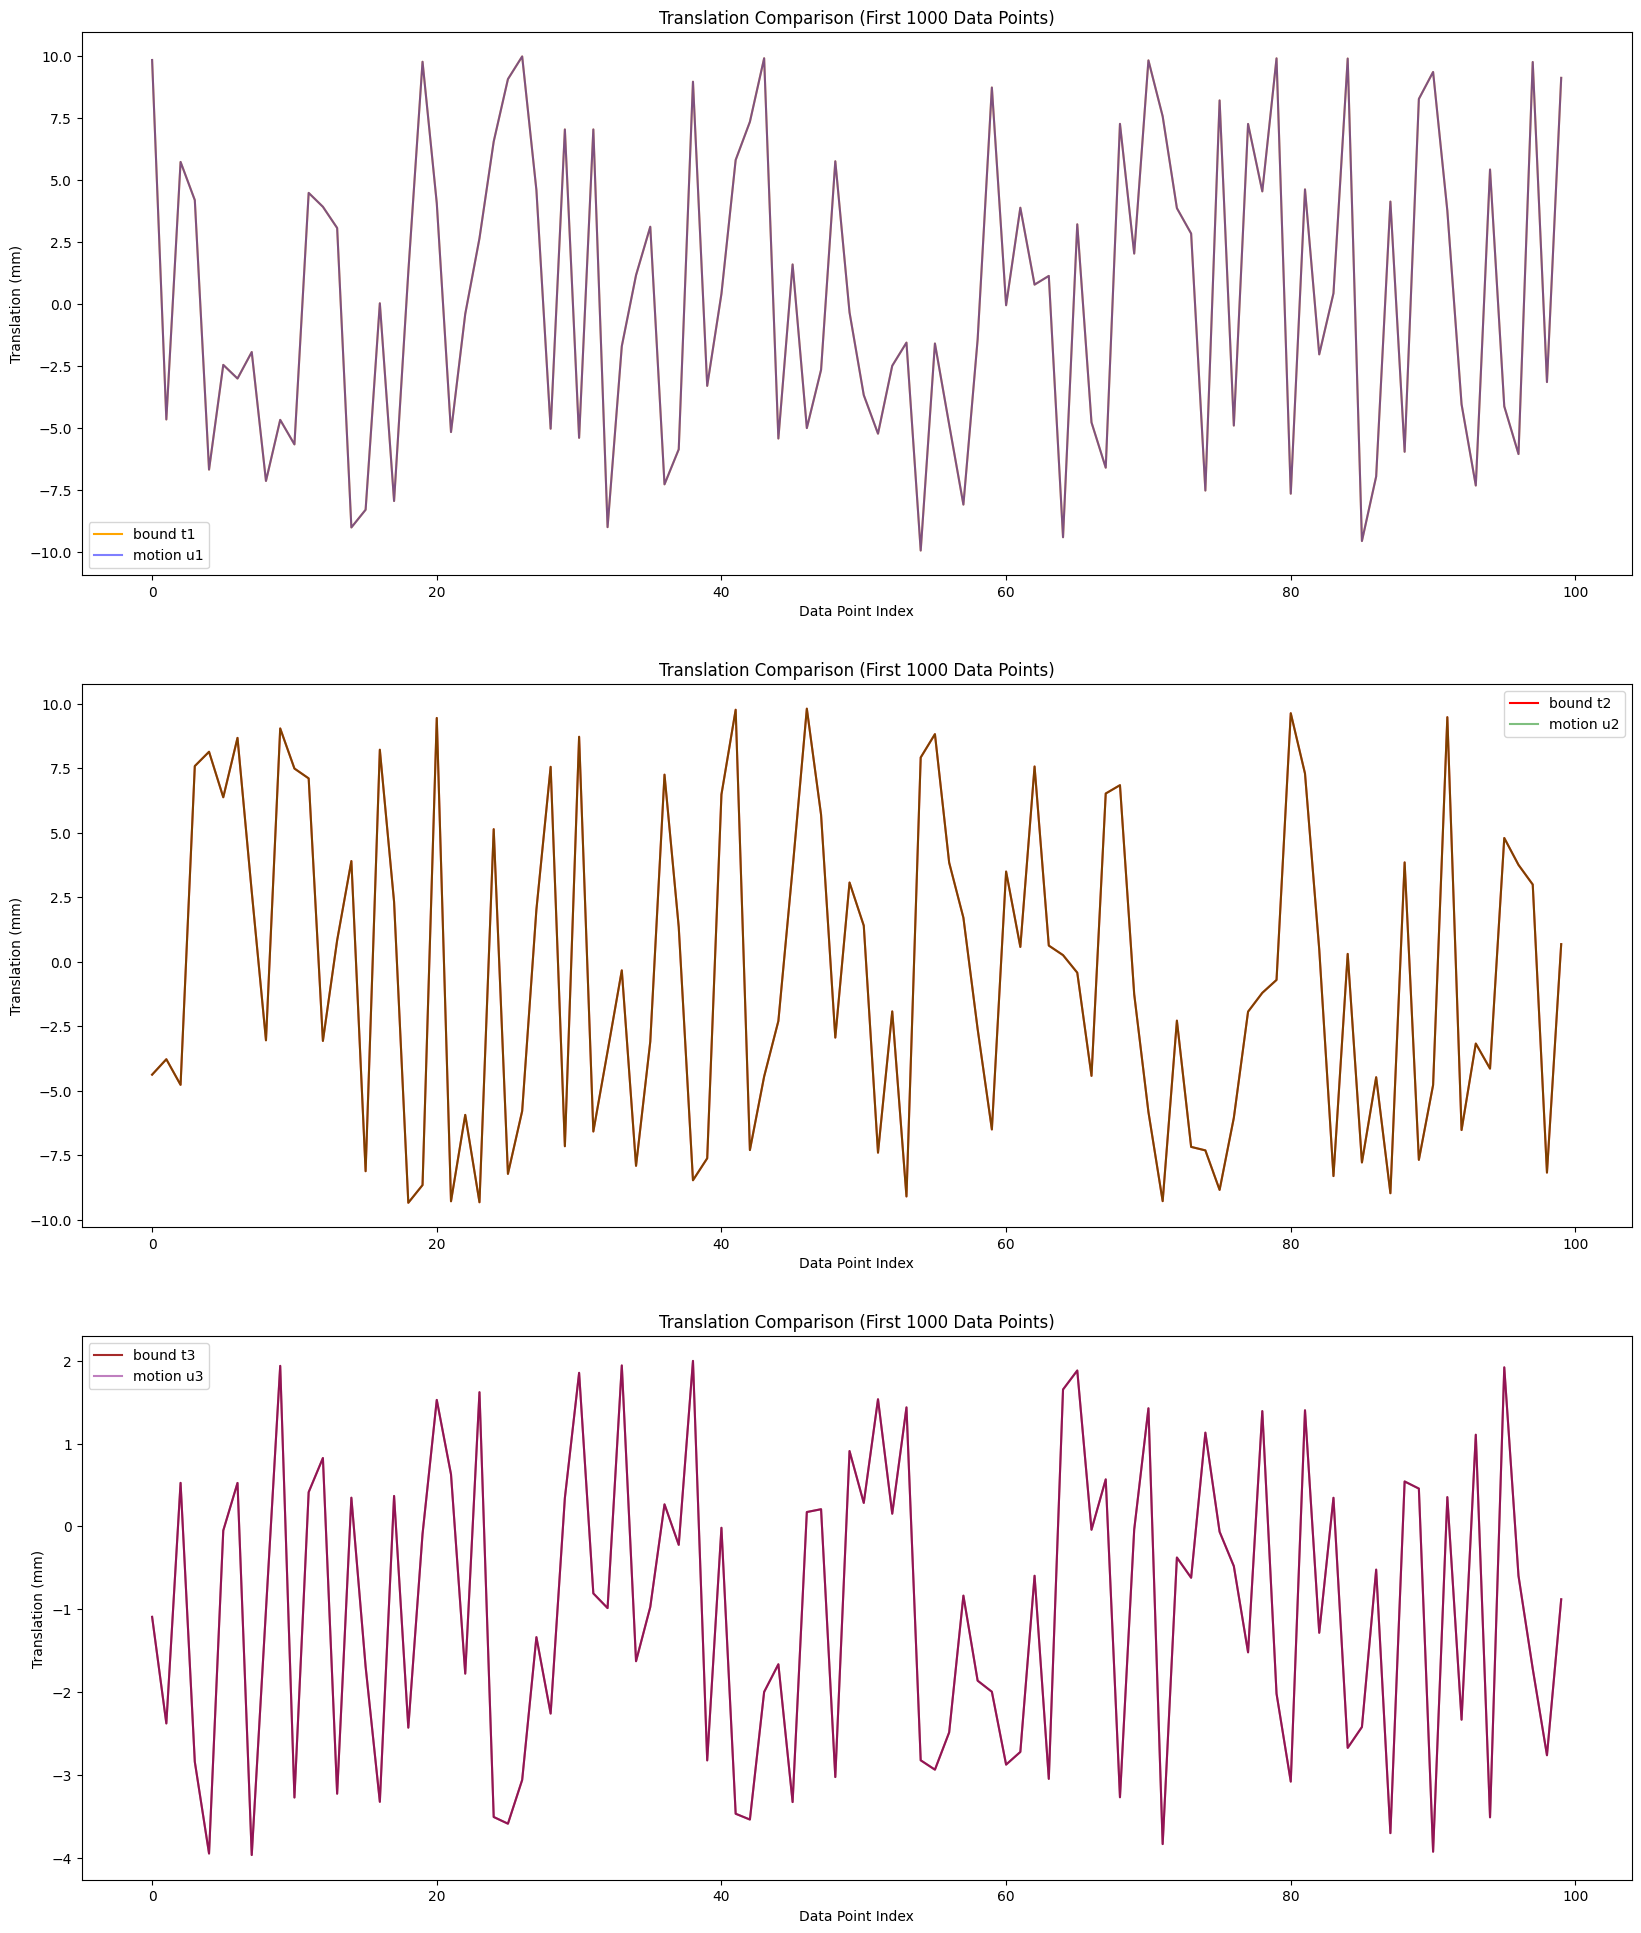

In [27]:
# compare the bound pose with the motion
motion = np.load(os.path.join(data_dir, "motion.npy"))
bound_pose = np.load(os.path.join(data_dir, "bound_pose.npy"))

# plot the first 1000 data points of translation
number = 100
plt.figure(figsize=(20, 24))
plt.subplot(3, 1, 1)
plt.plot(bound_pose[:number, 0], label="bound t1", color="orange")
plt.plot(motion[:number, 0], label="motion u1", color="blue", alpha=0.5)
plt.xlabel("Data Point Index")
plt.ylabel("Translation (mm)")
plt.title("Translation Comparison (First 1000 Data Points)")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(bound_pose[:number, 1], label="bound t2", color="red")
plt.plot(motion[:number, 1], label="motion u2", color="green", alpha=0.5)
plt.xlabel("Data Point Index")
plt.ylabel("Translation (mm)")
plt.title("Translation Comparison (First 1000 Data Points)")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(bound_pose[:number, 2], label="bound t3", color="brown")
plt.plot(motion[:number, 2], label="motion u3", color="purple", alpha=0.5)
plt.xlabel("Data Point Index")
plt.ylabel("Translation (mm)")
plt.title("Translation Comparison (First 1000 Data Points)")
plt.legend()

In [14]:
# Load the motion, force, and surface_node data
motion = np.load(os.path.join(data_dir, "motion.npy"))
print("motion shape:", motion.shape)
force = np.load(os.path.join(data_dir, "force.npy"))
print("force shape:", force.shape)
surface_node = np.load(os.path.join(data_dir, "surface_node.npy"))
print("surface_node shape:", surface_node.shape)

# Merge the data into one array
merged = np.concatenate([motion, force, surface_node[:, :, 1:].reshape(surface_node.shape[0], -1)], axis=1)
np.save(os.path.join(data_dir, "data.npy"), merged)
print("merged data shape:", merged.shape)

motion shape: (99711, 6)
force shape: (99711, 6)
surface_node shape: (99711, 954, 4)
merged data shape: (99711, 2874)


Check the shape of the data:

Then we split the data into training and testing sets with the ratio of 8:2:

In [28]:
# Set the split ratio
train_test_ratio = 0.8

# Load the data
data = np.load(os.path.join(data_dir, "data.npy"))
print("data shape:", data.shape)

# Shuffle the data
np.random.shuffle(data)
train_data = data[: int(len(data) * train_test_ratio)]
test_data = data[int(len(data) * train_test_ratio) :]

# Save the train and test data
np.save(os.path.join(data_dir, "train_data.npy"), train_data)
print("train_data shape:", train_data.shape)
np.save(os.path.join(data_dir, "test_data.npy"), test_data)
print("test_data shape:", test_data.shape)

data shape: (99711, 2874)
train_data shape: (79768, 2874)
test_data shape: (19943, 2874)


Now we have successfully prepared the dataset for training and testing the NeckNet model.

## Training

Before training the model, we need to define the model hyperparameters in `.configs/training.yaml`, including:

- `x_dim`: the input dimension of each modality, such as `[6, 6, 2862]` referring to the motion, force, and shape modalities.
- `z_dim`: the dimension of the latent code.
- `h1_dim_dict`: the dimension of the first hidden layers, corresponding to each modality and the dimension of the latent code.
- `h2_dim_dict`: the dimension of the second hidden layers, corresponding to each modality and the dimension of the latent code.
- `recon_est_scale`: the scale of the reconstruction loss and prediction loss.
- `kl_coef`: the coefficient of the KL divergence loss.
- `z_coef`: the coefficient of the latent loss.

Several arguments are also provided for `train.py`:

- `--lr`: the learning rate (default: 1e-5).
- `--batch_size`: the batch size (default: 128).
- `--epochs`: the number of epochs (default: 2000).

To train the model, run the following command:

```bash
python train.py
```

The logs will be saved in `./lightning_logs/` folder, and named by the timestamp.

## Export to ONNX

To make the model compatible with other platforms, we can export the trained model to ONNX format. The following command will export the model to `model.onnx` file:

```bash
python scripts/export_onnx.py --ckpt_path {ckpt_path}
```

The `ckpt_path` is the path to the checkpoint file of the trained model, which is usually in `./lightning_logs/` folder.

## Testing

Here we provide a simple example to test the model. We first load the model by defining the `onnx_path`:

In [ ]:
# Load the NeckNet model
onnx_path = "../models/NeckNet.onnx"
model = NeckNetRuntime(model_path=onnx_path)

Then we calculate the R2 score and RMSE of each modality and visualize the results with linear plots, taking the motion modality as the input and the force and shape modalities as the output:

In [ ]:
# Load the test data
test_data = np.load(os.path.join(data_dir, "test_data.npy"))

# Split the test data into motion, force, and node
sample_num = np.array(test_data).shape[0]
motion_gt = np.array(test_data[:, :6])
force_gt = np.array(test_data[:, 6:12])
node_gt = np.array(test_data[:, 12:])
node_gt = node_gt.reshape(sample_num, -1, 3)
print("motion_gt shape:", motion_gt.shape)
print("force_gt shape:", force_gt.shape)
print("node_gt shape:", node_gt.shape)

# Estimate the force and node using the model
force_est = []
node_est = []
print("Estimating force and node using the model...")
for i in tqdm(range(motion_gt.shape[0]), desc="Estimating", ncols=100):
    motion = motion_gt[i]
    force, node = model.infer(motion)
    force_est.append(force)
    node_est.append(node)
force_est = np.array(force_est).reshape(-1, 6)
node_est = np.array(node_est).reshape(sample_num, -1, 3)
print("force_est shape:", force_est.shape)
print("node_est shape:", node_est.shape)

In [ ]:
# Define the r2 score function
def r2_score(y_true: np.ndarray, y_est: np.ndarray) -> np.ndarray:
    if y_true.ndim == 1:
        return 1 - np.sum((y_true - y_est) ** 2) / np.sum(
            (y_true - np.mean(y_true)) ** 2
        )
    else:
        r2_list = []
        for i in range(y_true.shape[1]):
            r2 = 1 - np.sum((y_true[:, i] - y_est[:, i]) ** 2) / np.sum(
                (y_true[:, i] - np.mean(y_true[:, i])) ** 2
            )
            r2_list.append(r2)
        return np.array(r2_list)

# Define the root mean square error (rmse) function
def rmse(y_true: np.ndarray, y_est: np.ndarray) -> np.ndarray:
    if y_true.ndim == 1:
        return np.sqrt(np.mean((y_true - y_est) ** 2))
    else:
        rmse_list = []
        for i in range(y_true.shape[1]):
            rmse = np.sqrt(np.mean((y_true[:, i] - y_est[:, i]) ** 2))
            rmse_list.append(rmse)
        return np.array(rmse_list)

# Calculate r2 score
r2_force = r2_score(force_gt, force_est)
r2_node = r2_score(node_gt.reshape(-1, 3), node_est.reshape(-1, 3))
print("R2 score of force:", r2_force)
print("R2 score of node:", r2_node)

# Calculate rmse
rmse_force = rmse(force_gt, force_est)
rmse_node = rmse(node_gt.reshape(-1, 3), node_est.reshape(-1, 3))
print("RMSE of force:", rmse_force)
print("RMSE of node:", rmse_node)

In [ ]:
# Linear plot
def gt_est_plot(gt, pred, min, max, name, color):
    subplot_num = len(gt[0])
    fig = plt.figure(figsize=(3 * subplot_num, 3), dpi=200)
    for i in range(subplot_num):
        plt.subplot(1, subplot_num, i + 1)
        plt.plot(gt[:, i], pred[:, i], ".", color=color, markersize="1")
        plt.plot([min[i], max[i]], [min[i], max[i]], "k--", linewidth=0.8, alpha=0.5)
        plt.xlabel("Ground truth")
        plt.ylabel("Prediction")
        plt.xlim([min[i], max[i]])
        plt.ylim([min[i], max[i]])
        plt.xticks(np.arange(min[i], max[i] + 0.1, (-min[i] + max[i]) / 4))
        plt.yticks(np.arange(min[i], max[i] + 0.1, (-min[i] + max[i]) / 4))
        plt.grid()
        plt.gca().set_aspect("equal", adjustable="box")
    fig.suptitle(name)
    fig.tight_layout(pad=0.4, w_pad=0, h_pad=10)


rand_num = 5000
rand_idx_force = np.random.choice(len(force_gt), rand_num, replace=False)
rand_idx_node = np.random.choice(len(node_gt), rand_num, replace=False)
gt_est_plot(
    force_gt[rand_idx_force, :3],
    force_est[rand_idx_force, :3],
    [-30, -30, -50],
    [30, 30, 50],
    "Force",
    "#38bdf6",
)
gt_est_plot(
    force_gt[rand_idx_force, 3:],
    force_est[rand_idx_force, 3:],
    [-1000, -1000, -400],
    [1000, 1000, 400],
    "Torque",
    "#38bdf6",
)
gt_est_plot(
    node_gt[rand_idx_node, :, :].reshape(-1, 3),
    node_est[rand_idx_node, :, :].reshape(-1, 3),
    [-15, -15, -15],
    [15, 15, 15],
    "Shape",
    "#fc3839",
)

We can also manually input the motion data and visualize the mesh in 3D:

In [ ]:
# Set motion and predict force and shape
motion = np.array([6, -6, 0, -0.1, -0.1, 0])
# motion = np.array([0, 0, 0, 0, 0, 0])
force_infer, node_infer = model.infer(motion)
force_infer = force_infer.reshape(-1)
node_infer = node_infer.reshape(-1, 3)

# Print force
print("Inferred force:", force_infer)

# Load mesh and display the result
node_ori = np.loadtxt(surface_coordinate_txt_path, delimiter=",")
mesh_triangle = np.loadtxt(surface_triangle_txt_path, dtype=int, delimiter=",") - 1
deform_node = np.loadtxt(deform_node_txt_path, dtype=int)
node_curr = node_ori.copy()
node_curr[deform_node - 1] += node_infer.reshape(-1, 3)
mesh3d = go.Mesh3d(
    x=node_curr[:, 0],
    y=node_curr[:, 1],
    z=node_curr[:, 2],
    i=mesh_triangle[:, 0],
    j=mesh_triangle[:, 1],
    k=mesh_triangle[:, 2],
    intensity=np.linalg.norm(node_curr - node_ori, axis=1),
    colorscale="Viridis",
    autocolorscale=False,
    colorbar=dict(
        title=dict(
            text="Displacement (mm)",
            side="right",
            font=dict(size=16, family="Arial"),
        ),
        tickvals=[0, 4, 8, 12],
        tickfont=dict(size=14, family="Arial"),
        len=0.5,
    ),
    cmin=0,
    cmax=12,
    showscale=True,
    flatshading=True,
)
fig = go.Figure(data=[mesh3d])
fig.update_layout(
    scene=dict(
        camera=dict(
            eye=dict(x=1, y=1, z=1),
            projection=dict(type="orthographic"),
        ),
        xaxis=dict(nticks=4, range=[-50, 50]),
        yaxis=dict(nticks=4, range=[-50, 50]),
        zaxis=dict(nticks=4, range=[0, 100]),
        aspectmode="manual",
        aspectratio=go.layout.scene.Aspectratio(x=1, y=1, z=1),
    ),
    margin=dict(l=0, r=0, b=0, t=0, pad=0),
)
fig.show()